## Week 9: Sequence Modelling and Embeddings

Instructor: Cornelia Ilin <br>
Email: cilin@ischool.berkeley.edu <br>

#### ``Objectives``
1. Learn how to represent sequential data
2. Implement a multilayer NN for sentiment analysis using a **many-to-one** architecture
3. In the process, you will learn how to learn embeddings from scratch (as opposed to transfer learning)

Image source: https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch16/ch16_part1.ipynb 



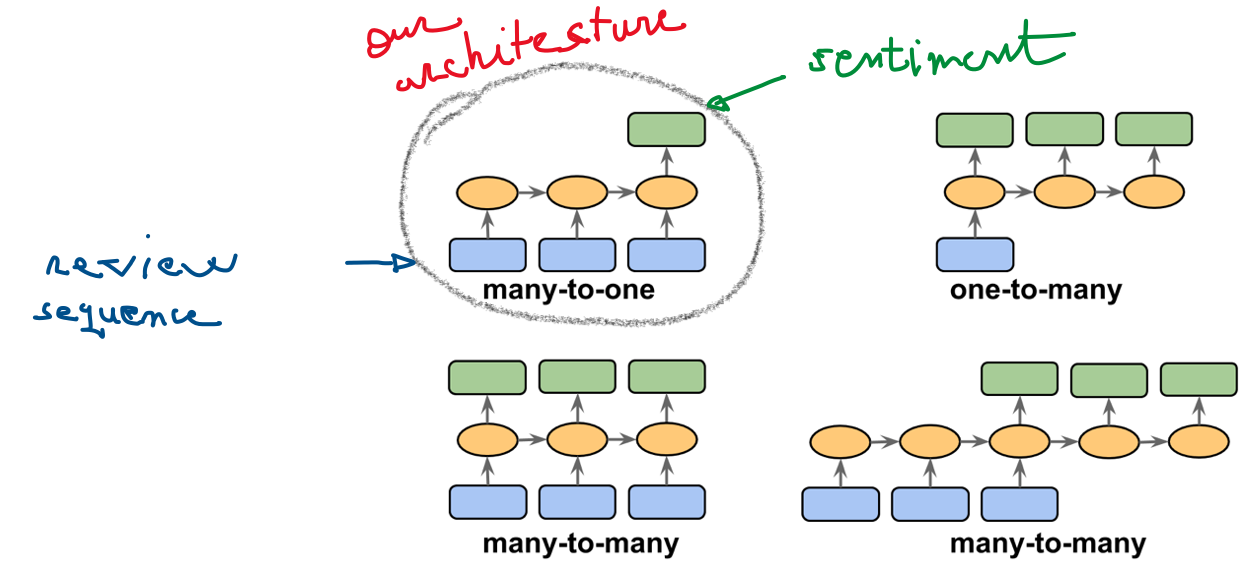

In [1]:
from IPython.display import Image
print('Image source: https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch16/ch16_part1.ipynb \n')
Image(filename='./images/architecture.png', width=600) 

#### ``Motivation``

Drug reviews can provide medical care information for both healthcare professionals and patients. They help understand the side effects and effectiveness level of drugs before prescribing or taking them.

Image source: https://www.mcmasteroptimalaging.org



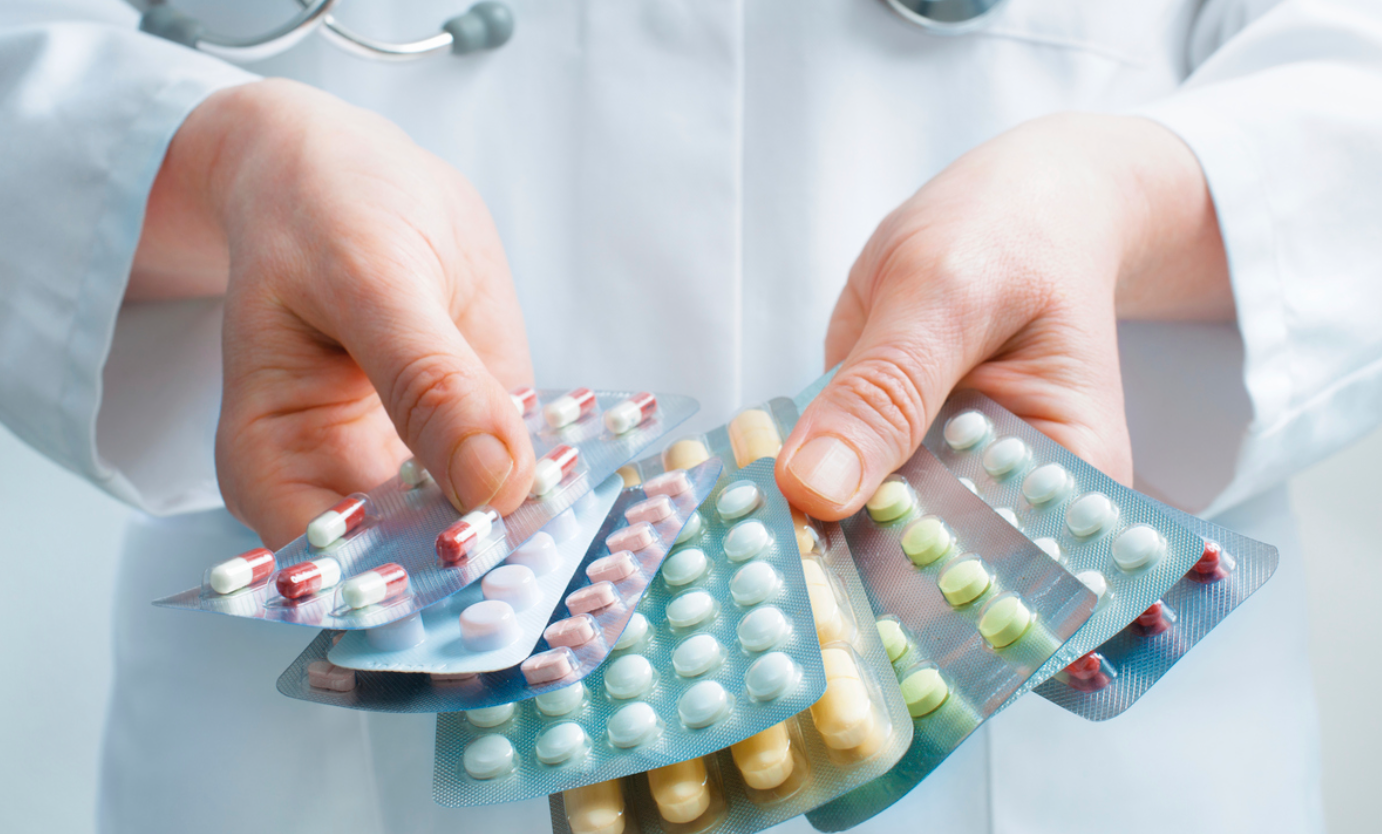

In [2]:
print('Image source: https://www.mcmasteroptimalaging.org\n')
Image(filename='./images/drugs.png', width=400) 

#### ``Data``

Our data ([download link](https://drive.google.com/file/d/1ZWzmnIykk63pJuEBTonxbC4CBXJjI6t5/view?usp=sharing)) provides patient reviews on specific drugs and related conditions, and a 10-star rating reflecting overall patient satisfaction. The data was obtained by crawling online pharmaceutical review sites.

We will **build** and **train** a multilayer **NN model** to predict if a review is positive (1) or negative (0).


<u>Note</u>: the original dataset is hosted by UCI - Machine Learning Repository [[Source]](https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29).

**Feature information**:

1. drugName (categorical): name of drug 
2. condition (categorical): name of condition 
3. review (text): patient review 
4. rating (numerical): 10 star patient rating 
5. date (date): date of review entry 
6. usefulCount (numerical): number of users who found review useful

Import the necessary libraries and make sure to replace DATA_PATH with the path to the directories where you saved the data.

In [3]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout
import tensorflow_datasets as tfds

# shap
import shap

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

# others
import re
from sklearn.decomposition import PCA
from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


random.seed(2)
%matplotlib inline

# FILL IN CODE HERE #
DATA_PATH = '' # replace with your path

``Functions``

In [4]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

In [5]:
# define function for token encoder
def encode(text_tensor, label):
    text = text_tensor.numpy()[0]
    encoded_text = encoder.encode(text)
    return encoded_text, label

#  wrap the encode function to a TF Operator
def encode_map_fn(text, label):
    return tf.py_function(encode, inp=[text, label], 
                          Tout=(tf.int64, tf.int64))

---
## Read data

First, let's read the data into a pandas dataframe. 

In [6]:
df_init = pd.read_csv('./data/drugs_raw.csv')
print('Number of reviews:', df_init.shape[0])
print('Reviews collected between:', df_init.date.min(), 'and ', df_init.date.max())
print('Unique rating values:', np.sort(df_init.rating.unique()))
df_init.head()

Number of reviews: 215063
Reviews collected between: April 1, 2008 and  September 9, 2017
Unique rating values: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


There are 215,063 product reviews (entered between 2008 and 2017) whose content is stored in the **review** column.  The text component of these drug reviews is <span style="color:chocolate">sequences of words</span>. Each review is associated with a rating value between 1 and 10. We will use a NN to classify these sentences positively or negatively based on the expressed sentiment.

``Word cloud: reviews of one drug``

We will plot the **word cloud** for Fluoxetine, an antidepressant that belongs to a group of medicines known as selective serotonin reuptake inhibitors (SSRIs). This medicine works by increasing the activity of a chemical called serotonin in the brain [[Source]](https://www.mayoclinic.org/drugs-supplements/fluoxetine-oral-route/description/drg-20063952).

The ``wordcloud`` pakage provides a class, ``WordCloud``, which we can use to visualize the frequency/importance of tokens in our dataset. You can read more about wordcloud here: https://pypi.org/project/wordcloud/.

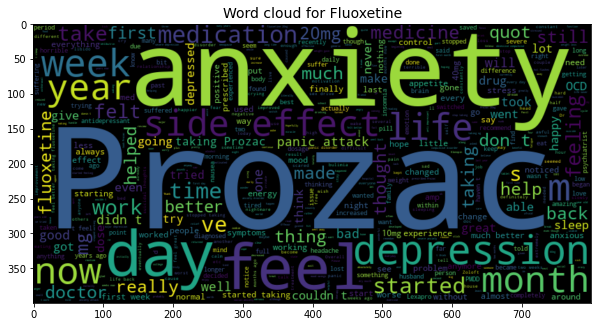

In [7]:
# keep only reviews related to Fluoxetine
df_fluoxetine = df_init[df_init.drugName.eq('Fluoxetine')]

plt.figure(figsize = (10,10))
wc = WordCloud(
    max_words = 500,
    width = 800,
    height = 400).generate(" ".join(df_fluoxetine.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Fluoxetine',fontsize=14);

---
## Data preprocessing

Before we can feed the sentiment data into an NN model, we need to apply a few preprocessing steps:
   1. Strip reviews of all unwanted characters
   2. Create a binary sentiment column based on rating scores. This will be the target value we want to predict.
   3. Create TensorFlow data and split into train, validation, and test partitions
   4. Identify unique words in the training dataset
   5. Map each unique word to a unique integer and encode the review text into encoded integers
   6. Divide the dataset into mini-batches as input to the model
   7. Create features (embeddings)

``Step 1: Remove unwanted review characters``

In [8]:
# remove HTML markup, punctuation, and other non-letter characters
df_init['review'] = df_init['review'].apply(preprocessor)

``Step 2: Create binary sentiment column``

We will define our sentiment column as follows:

   - positive (1) if rating score is between 8-10
   - negative (0) if rating score is between 1-3
    
We dill drop any reviews that are netural, i.e., rating is between 4-7.

Let's take a look at the rating histogram before we do any data preprocessing.

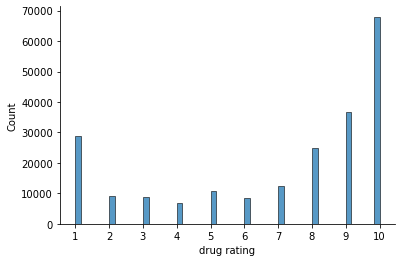

In [9]:
# rating hist
ax = sns.histplot(
    data=df_init,
    stat="count",
    x = "rating"
)

# add labels and ticks
ax.set(xlabel='drug rating')
plt.xticks(np.arange(1,11,1))
sns.despine()

Next, we will create the binary sentiment column. Remember this will be our target of interest.

In [10]:
# create sentiment column
df_init['sentiment'] = np.where(df_init.rating.isin((1, 2, 3)), 'negative',
                          np.where(df_init.rating.isin((8,9,10)), 'positive', 'neutral'))

# drop review if sentiment is netural
df = df_init[~df_init.sentiment.eq('neutral')]

# rename sentiment to positive = 1, negative = 0
df['sentiment'] = np.where(df.sentiment.eq('positive'), 1, 0)

Finally, let's do a quick inspection of our rating and sentiment columns, to make sure our code did what we intended it to do.

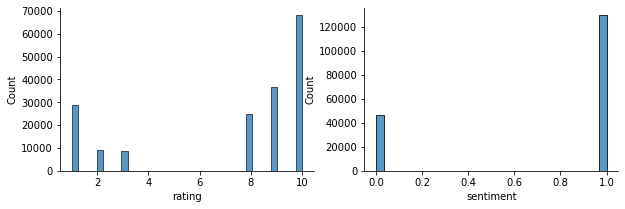

In [11]:
# rating and sentiment histogram after preprocessing
cols = ['rating', 'sentiment']
nrows, ncols = 1, 2

f, axs = plt.subplots(1, 2, figsize=(10,3))
for idx, ax in enumerate(axs):
    sns.histplot(
    data=df,
    stat="count",
    x = cols[idx],
    ax=ax
    )

    # add labels and ticks
    ax.set(xlabel=cols[idx])
    #plt.xticks(np.arange(1,11,1))
    sns.despine()

In [12]:
print('Number of positive reviews:', df[df.sentiment.eq(1)].shape[0])
print('Number of negative reviews:', df[df.sentiment.eq(0)].shape[0])

Number of positive reviews: 129759
Number of negative reviews: 46901


As you can see from the sentiment histogram above, our dataset is very imbalanced. We will correct for class imbalance by taking only 46,000 random examples from each class. Again, this is a crude method (we undersample the positive class) but good enough for starters.

In [13]:
# randomly draw 46000 examples from each class
temp_positive = df[df.sentiment.eq(1)].sample(
    n=46000,
    replace=False
)

temp_negative = df[df.sentiment.eq(0)].sample(
    n=46000,
    replace=False
)

df_balanced = pd.concat(
    [temp_positive, temp_negative],
    axis=0)

# shuffle df_balanced
df_balanced.sample(frac=1) # frac=1 retains all the data
df_balanced.reset_index(drop=True, inplace=True) # reset index

print('After preprocessing, our data contains', df_balanced.shape[0], 'reviews.')

After preprocessing, our data contains 92000 reviews.


``Step 3: Create TensorFlow dataset and split into training, val, test``

<span style="color:chocolate">keep only review and sentiment columns</span>

In [14]:
df_balanced = df_balanced[['review', 'sentiment']]
df_balanced.head(5)

,review,sentiment
0,i 039 ve been using this pill for three weeks...,1
1,tenex works great for my daughter in the spec...,1
2,having been a serious and functioning alcohol...,1
3,i 039 m just finishing my 1st pack of yaz and...,1
4,not nauseous as i was with previous medicatio...,1


<span style="color:chocolate">create TensorFlow dataset</span> 

In [15]:
# define target
target = df_balanced.pop('sentiment') # .pop removes sentiment col from df

# target and review combined tensors
data_tf = tf.data.Dataset.from_tensor_slices(
    (df_balanced[['review']].values, target.values)
)

In [16]:
# inspection of the first 5 examples
for example in data_tf.take(5):
    # print review (first 40 characters) and sentiment (label)
    tf.print(example[0].numpy()[0][:40], example[1])

b' i 039 ve been using this pill for three' 1
b' tenex works great for my daughter in th' 1
b' having been a serious and functioning a' 1
b' i 039 m just finishing my 1st pack of y' 1
b' not nauseous as i was with previous med' 1


<span style="color:chocolate">split data into train, validation, and test partitions</span> 

In [17]:
# set random seed
tf.random.set_seed(1)

# define splits for training, validation, test
splits=[0.6, 0.2, 0.2] 

# shuffle data
data_tf = data_tf.shuffle(
    df_balanced.shape[0], reshuffle_each_iteration=False)

data_tf_test = data_tf.take(int(df_balanced.shape[0]*splits[2]))
data_tf_train_valid = data_tf.skip(int(df_balanced.shape[0]*splits[2]))
data_tf_train = data_tf_train_valid.take(int(df_balanced.shape[0]*splits[0]))
data_tf_valid = data_tf_train_valid.skip(int(df_balanced.shape[0]*splits[0]))

``Step 4: Identify unique words (tokens) in the training dataset``

We will use the ``Counter`` class in the ``Collection`` package to extract the unique words in our train data (this is going to be our vocabulary). Note that we split the text into words (tokens) using the Tokenizer class in tensorflow_datasets.

Collection package (Counter class): https://docs.python.org/3/library/collections.html#collections.Counter

TensorFlow Tokenizer: https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/Tokenizer

In [18]:
# try and except the TF tokenizer
try:
    tokenizer = tfds.features.text.Tokenizer()
except AttributeError:
    tokenizer = tfds.deprecated.text.Tokenizer()

# create an instance of the Counter class
token_counts = Counter()

for example in data_tf_train:
    tokens = tokenizer.tokenize(example[0].numpy()[0])
    token_counts.update(tokens)
    
print('Size of training vocabulary:', len(token_counts))

Size of training vocabulary: 33210


In [19]:
# remove comment if you want to see the vocabulary
# number in paranthesis represent the frequency of each word (only needed if you build a bag-of-word model)
#display(token_counts)

Let's print the first example in our training dataset to see how the text was split into tokens and later added to our token_counts.

In [20]:
# first example
print('Print second review in training data:')
print('------')
for idx, example in enumerate(data_tf_train.take(2)):
    if idx==1:
        print(example[0].numpy())
        token = tokenizer.tokenize(example[0].numpy()[0])
    
print('\nPrinting the first 10 tokens:')
print('------')
[val for idx, val in enumerate(token) if idx <12]

Print second review in training data:
------
[b' i 039 ve been taking benedryl allergy every four hours today to try to get some relief from my hives but it hasn 039 t helped at all the most relief i felt was during an oatmeal bath ']

Printing the first 10 tokens:
------


['i',
 '039',
 've',
 'been',
 'taking',
 'benedryl',
 'allergy',
 'every',
 'four',
 'hours',
 'today',
 'to']

``Step 5. Encoding: sequences of words into sequences of integers``

The idea here is to map each unique word (token) in our training vocabulary to a unique integer. The tensorflow_dataset package provides a class, TokenTextEncoder, which we will use to create a mapping between words and corresponding integers.

TensorFlow token encoder: https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/TokenTextEncoder

In [21]:
# create an instance of the TF encoder class
try:
    encoder = tfds.features.text.TokenTextEncoder(token_counts) # token_counts contains our training vocabulary
except AttributeError:
    encoder = tfds.deprecated.text.TokenTextEncoder(token_counts)

# try an example first (first 12 characters from the second review in training data)
example_str = 'My son took generic for about 6 months. His dr actually prescribed'
encoder.encode(example_str) # the encode method transforms the text into integers

[33211, 2421, 7, 2133, 9, 337, 63, 124, 33211, 1166, 482, 780]

<span style="color:chocolate">Very important!</span> Our validation and test data may include tokens that are not present in the training data! 

Our training dataset has `q = 42785` unique tokens (this is the size of token_counts). The TF text enoder reserves the integer `q+1` (42786 in our case) for words that haven't been seen before (unknown words). Another reserved value is the integer `0`, which serves as a placeholder for adjusting sequence length (a.k.a., <span style="color:chocolate">PADDING</span>).

Next, we will apply apply the token encoder to our entire training vocabulary.

In [22]:
# the encode_map_fn is defined at the top of the notebook
data_tf_train = data_tf_train.map(encode_map_fn)
data_tf_valid = data_tf_valid.map(encode_map_fn)
data_tf_test = data_tf_test.map(encode_map_fn)

In [23]:
# print first two examples in training data
for example in data_tf_train.take(2):
    print ('----------------------------')
    print('Sequence length:', example[0].shape)
    print('Integer sequence:\n', example[0].numpy())


----------------------------
Sequence length: (30,)
Integer sequence:
 [ 1  2  3  4  5  6  7  8  9 10 11 12  4 13  3 14 15 16 17 18 11  4 14 19
 20 12 21 22 23 24]
----------------------------
Sequence length: (38,)
Integer sequence:
 [ 6 25 26 27 28 29 30 31 32 33 34 35 36 35 37 38 39 40  4 41 42 43 44 25
 45 46 47 48 16 49 39  6 50 51 52 53 54 55]


``Step 6: Divide the dataset into mini-batches as input to the model``

<span style="color:chocolate">Very important!</span> Our training sequences have different lengths (e.g., 134 vs. 25 tokens following the example printed above). We need to make sure that all sequences in a mini-batch have the same length to store them efficiently in a tensor.


TensorFlow provides a ``padded_batch()`` method that will automatically add padding (i.e., add 0s as placeholder values) to each mini-batch. The sequence length for each mini-batch is determined by the maximum size of the examples in that particular batch.

Let's look at an example:

In [24]:
# take a small subset from training data and print len of sequence
data_tf_train_subset = data_tf_train.take(8)
for idx, example in enumerate(data_tf_train_subset):
    if idx%3==0:
        print('-------------')
    print('Individual size:', example[0].shape)

-------------
Individual size: (30,)
Individual size: (38,)
Individual size: (59,)
-------------
Individual size: (64,)
Individual size: (23,)
Individual size: (13,)
-------------
Individual size: (13,)
Individual size: (159,)


In [25]:
# divide the data into mini-batches of size 3
data_tf_batched = data_tf_train_subset.padded_batch(
    3,
    padded_shapes=([-1], []))

for batch in data_tf_batched:
    print('Batch dimension:', batch[0].shape)

Batch dimension: (3, 59)
Batch dimension: (3, 64)
Batch dimension: (2, 159)


Let's see how **padded_batch()** performed padding by looking at the examples in the first mini-batch. The first mini-batch contains 3 examples. These are the first 3 reviews in our training data. Note that the max sequence length of the first batch is 134 (this is the size of the first review in our train data, so no 0 padding is applied to the first example).

In [26]:
for example in data_tf_batched.take(1):
    print(example[0].numpy())

[[ 1  2  3  4  5  6  7  8  9 10 11 12  4 13  3 14 15 16 17 18 11  4 14 19
  20 12 21 22 23 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0]
 [ 6 25 26 27 28 29 30 31 32 33 34 35 36 35 37 38 39 40  4 41 42 43 44 25
  45 46 47 48 16 49 39  6 50 51 52 53 54 55  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0]
 [ 4 56 57 58 59 60 61 62 63 64 65  6 66 67 59 68 69 70 71 67 34 72 69 73
  16 67 74 75 76 77 78  6 75 79 80 81 82  6 51 59 83 84 85 70 86 25 45 79
  87  6 88 16 89 90 84 85 91 92 93]]


<span style="color:chocolate">Divide all datasets into mini-batches</span>

In [27]:
# define batch size
batch_size = 32

# batcing of training, validation and test partitions
train_data = data_tf_train.padded_batch(
    batch_size,
    padded_shapes=([-1],[]))

valid_data = data_tf_valid.padded_batch(
    batch_size,
    padded_shapes=([-1],[]))

test_data = data_tf_test.padded_batch(
    batch_size,
    padded_shapes=([-1],[]))

Average sequence length in training mini-batches: 168


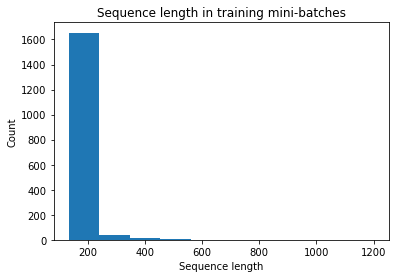

In [28]:
# histogram of sequence length in training mini-batches
seq_len_train = []
for batch in train_data:
    seq_len_train.append(batch[0].shape[1])
    
print('Average sequence length in training mini-batches:',
      int(sum(seq_len_train)/len(seq_len_train))
)

# histogram
plt.hist(seq_len_train)
plt.title('Sequence length in training mini-batches')
plt.ylabel('Count')
plt.xlabel('Sequence length');

``Step 7: Create features (embeddings)``

In the previous step, we generated sequences of same length for each mini-batch. The elements of each of these sequences are integer numbers that correspond to the indices of unique words.

Now we need to convert these word indices into features. We can do this in different ways:

   1. apply one-hot encodings to convert the indices into vectors of zeros and ones (very sparse! course of dimensionality!)
   2. map each of these words to a vector of fixed size with real-valued elements. This is the idea behind <span style="color:chocolate">embeddings</span>: learn salient features to represent words in our dataset. 

Image source: https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch16/ch16_part1.ipynb 



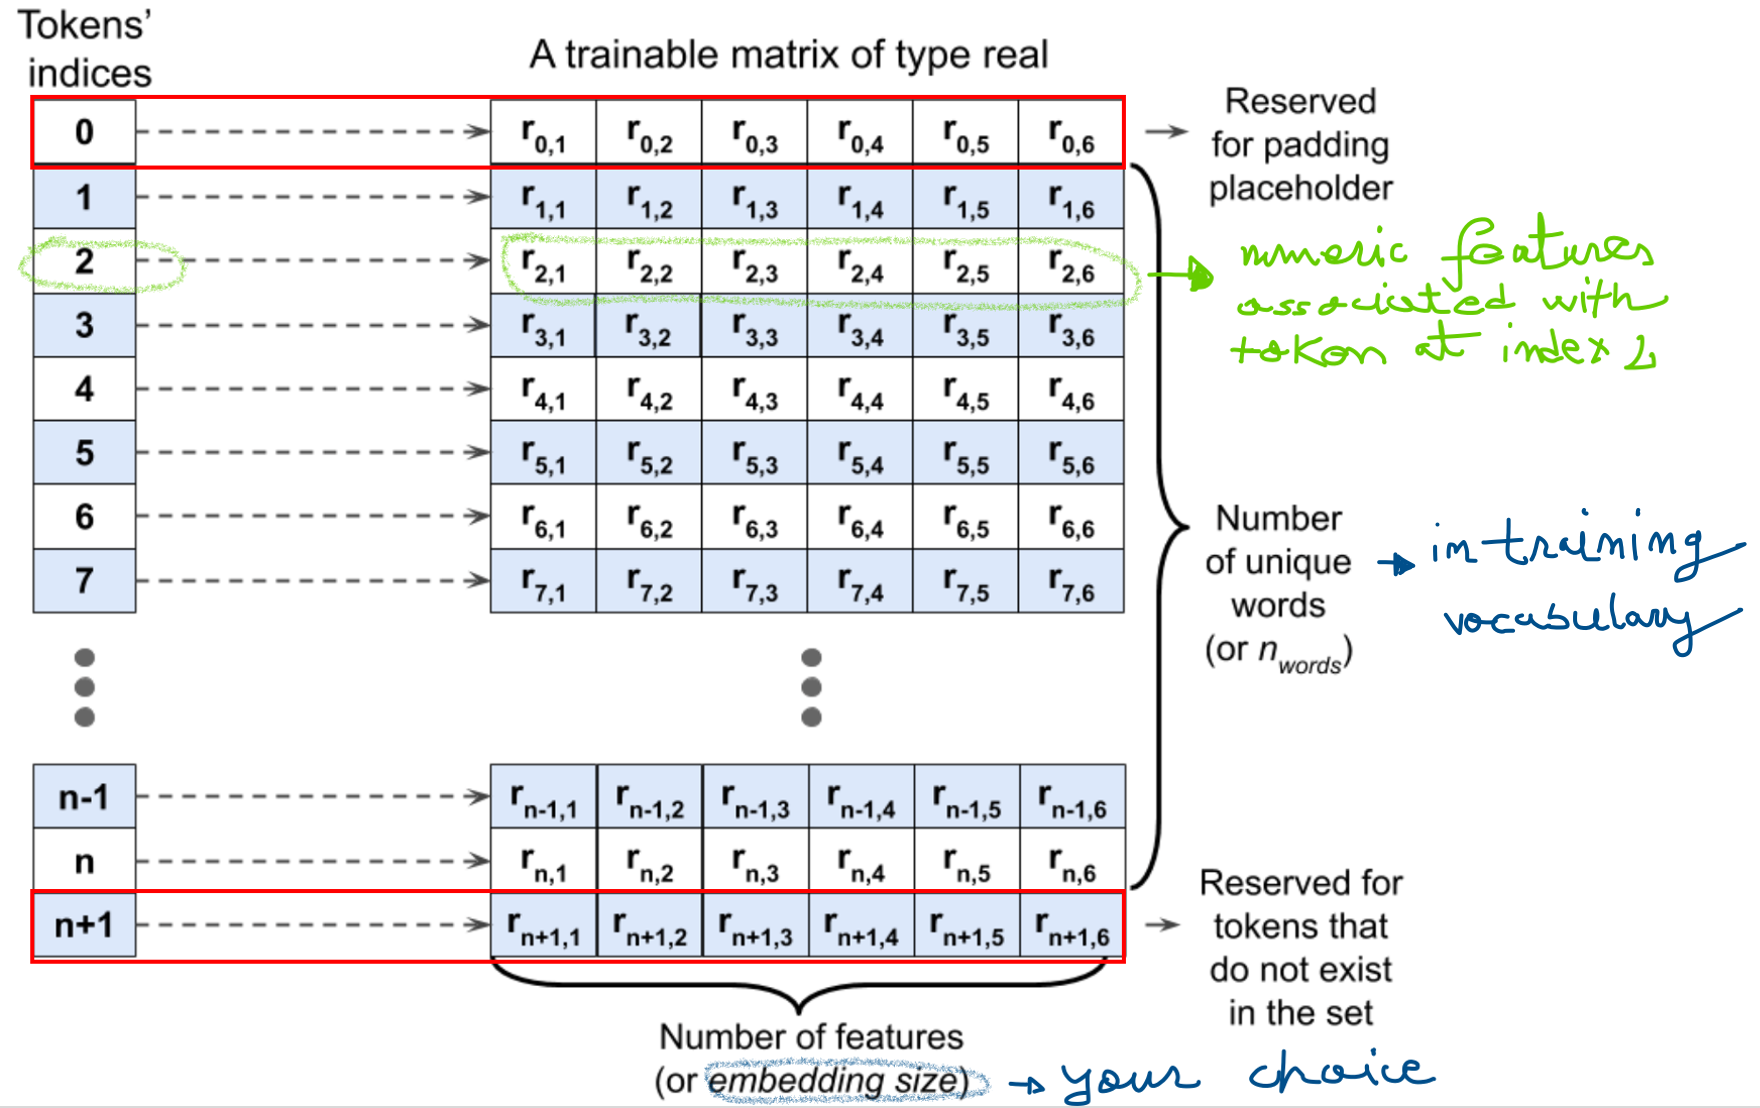

In [29]:
print('Image source: https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch16/ch16_part1.ipynb \n')
Image(filename='./images/embeddings.png', width=700) 

Each row of the embedding matrix represents numberic features associated with a token. Therefore, the embedding (feature) matrix is our input layer in a NN.

How do you choose the ``embedding size``? Common to use 8-dimensional (for small datasets) and up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn! 

The embedding layer can be easily obtained with Keras:

In [30]:
# Embed our training vocabulary into 20 dimensions.
vocab_size_train = len(token_counts) + 2
embedding_dim = 32

embedding_layer = tf.keras.layers.Embedding(
    vocab_size_train,
    embedding_dim,
)

<span style="color:chocolate">Important!</span> When you create an Embedding layer, the weights for the embedding are randomly initialized (just like any other layer!). These weights are  gradually adjusted via backpropagation.

Once trained, the learned word **embeddings** will roughly **encode similarities between words** (as they were learned for the specific problem your model is trained on).

Let's pass our first example in the training dataset through our embedding layer. The result replaces each integer with the vector from the embedding table:

In [31]:
for example in train_data.take(1):
    print('Seq length of our first training example:', example[0].numpy()[0].shape[0])
    print("Print integers of example:")
    print(example[0].numpy()[0])
    result = embedding_layer(example[0])

print("\nPrint embeddings of example:")
result_df = pd.DataFrame(result[0].numpy())
display(result_df.head())
print("Embedding size:", result_df.shape)

Seq length of our first training example: 159
Print integers of example:
[ 1  2  3  4  5  6  7  8  9 10 11 12  4 13  3 14 15 16 17 18 11  4 14 19
 20 12 21 22 23 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]

Print embeddings of example:


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,-0.034383,0.044283,0.030456,0.048127,0.048334,-0.045737,-0.007386,0.006110,-0.011646,-0.030332,...,-0.046386,0.021533,-0.044337,-0.039169,0.015789,-0.026284,0.029991,0.009369,-0.023762,0.015025
1,0.003026,0.042581,0.047641,-0.011104,-0.009052,0.024080,0.001336,-0.024532,-0.040454,-0.049620,...,-0.039218,-0.007597,0.002355,0.005848,-0.028471,0.011007,0.037642,0.010282,-0.012968,0.020197
2,-0.019871,-0.012958,-0.048746,0.003128,-0.047431,0.003426,0.032816,-0.010272,-0.039612,-0.048324,...,0.010282,-0.009806,0.018090,0.035509,-0.033756,0.006102,-0.021623,-0.041701,0.005157,0.015241
3,-0.048209,-0.009731,0.008839,0.008257,0.008363,0.008452,-0.017091,0.029331,-0.023412,0.047391,...,0.002017,0.047053,-0.039022,-0.044570,0.023183,0.041454,-0.036885,-0.020564,0.017481,-0.018423
4,0.014807,0.012171,0.010456,0.031257,-0.010994,-0.041272,-0.019369,-0.021296,0.018762,0.004402,...,-0.036517,-0.000531,0.017889,0.017907,-0.009336,-0.042766,0.002862,-0.049765,0.045307,-0.024298


Embedding size: (159, 32)


---
## Model

Our objective is to build and train a NN model to detect if a drug review is positive or negative.

<u>The architecture of our NN model is as follows</u>:

1. [add here]

``Build model``

We will use the **Keras Sequential** API to define our sentiment classification model.

In [32]:
vocab_size_train = len(token_counts) + 2
embedding_dim = 10

model = tf.keras.Sequential()
# add embedding layer (this is our imput layer)
# embeddings will be learned during training
# the weights for the embeddings are randomly initialized (just like any other layer!)
model.add(Embedding(
    vocab_size_train,
    embedding_dim,
    #input_length=100, #limits length of sentence to 100 tokens
    name="embedding")
    ),


# average over the emedding dimension, so each review is represented by a 1 vector of size embedding_dimension
model.add(GlobalAveragePooling1D()),

# add a Dense layer of dimension 16
model.add(Dense(6, activation='relu')),

# add Dropout for regularization
model.add(Dropout(0.5))

# add last layer (binary classification task)
model.add(Dense(1, activation='sigmoid'))


# save embeddings before training 
embeddings_untrained = model.get_layer('embedding').get_weights()[0]

# print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 10)          332120    
                                                                 
 global_average_pooling1d (G  (None, 10)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 66        
                                                                 
 dropout (Dropout)           (None, 6)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 332,193
Trainable params: 332,193
Non-trainable params: 0
__________________________________________________

``Compile model``

In [33]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'])

``Fit model``

Finally, we will fit the model with 2 epochs on the train set and validate on the validation set. The performance depends on the current starter hyperparameters such as learning rate and choice of optimizer.

In [34]:
# set random seed to get reproductible results 
# neural network algorithms are stochastic (e.g., due to random weight initialization); setting a random seed helps to get more stable results after each run
# however, best way to deal with randomness is to repeat your experiment many times (30+) and use statistics to summarize the performance of the model
tf.random.set_seed(1)
np.random.seed(1)
history = model.fit(
    train_data, 
    validation_data=valid_data, 
    epochs=5)

Epoch 1/5
1725/1725 [==============================] - 60s 34ms/step - loss: 0.5718 - accuracy: 0.7036 - val_loss: 0.4153 - val_accuracy: 0.8427
Epoch 2/5
1725/1725 [==============================] - 62s 36ms/step - loss: 0.4271 - accuracy: 0.8061 - val_loss: 0.3550 - val_accuracy: 0.8611
Epoch 3/5
1725/1725 [==============================] - 68s 39ms/step - loss: 0.3871 - accuracy: 0.8303 - val_loss: 0.3334 - val_accuracy: 0.8674
Epoch 4/5
1725/1725 [==============================] - 66s 38ms/step - loss: 0.3603 - accuracy: 0.8449 - val_loss: 0.3199 - val_accuracy: 0.8727
Epoch 5/5
1725/1725 [==============================] - 65s 38ms/step - loss: 0.3451 - accuracy: 0.8528 - val_loss: 0.3175 - val_accuracy: 0.8734


Next let's plot loss and accuracy for training and validation sets

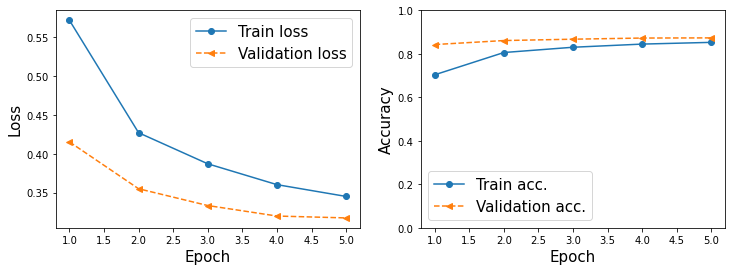

In [35]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,1)
plt.show()

In [36]:
print('After training this model for 10 epochs, evaluation on the validation data shows an accuracy of:')
print(np.round(hist['val_accuracy'][-1]*100,2), '%')

After training this model for 10 epochs, evaluation on the validation data shows an accuracy of:
87.34 %


<span style="color:chocolate">Question:</span> What's going on with our validation loss?

---
## Inspecting Learned Embeddings

Next, retrieve the word embeddings learned during training. The embeddings are weights of the Embedding layer in the model. The weights matrix is of shape (vocab_size_train, embedding_dim). 

We will obtain the weights from the model using `get_layer()` and `get_weights()`. 

In [37]:
# retrieve embeddings after training (weights)
embeddings_trained = model.get_layer('embedding').get_weights()[0]

# remove embedings at index 0 and last index
# these correspond to the additional indeces added for padding (0) and out of vocabulary words (size_train_vocab + 1).
embeddings_trained = embeddings_trained[1:-1]
embeddings_untrained = embeddings_untrained[1:-1] # for untrained too

# retrieve vocabulary
train_vocab = []
for token in token_counts.keys():
    train_vocab.append(token)
print('Size of trained embeding matrix:', embeddings_trained.shape)
print('Size of training vocabulary:', len(token_counts))

Size of trained embeding matrix: (33210, 10)
Size of training vocabulary: 33210


For word (token) at index 3 in vocabulary print the untrained and trained embeddings:

In [38]:
print('Word at index 4 in train vocab is:', train_vocab[3])
temp_df = pd.DataFrame({'untrained':embeddings_untrained[4], 'trained': embeddings_trained[4]}).T
print('Print embeddings:')
display(temp_df)

Word at index 4 in train vocab is: my
Print embeddings:


,0,1,2,3,4,5,6,7,8,9
untrained,-0.011810,0.022555,-0.001849,0.004458,-0.046391,-0.038309,0.031844,0.036212,0.047907,-0.008757
trained,0.060311,-0.018997,-0.053446,0.043930,-0.092843,0.000470,0.025898,0.044358,-0.016414,0.033127


``apply PCA to reduce embeddings to 2D``

PCA is usually implemented to reduce the dimensionality of word embedding. It helps with data visualization (e.g., in a 2D space). 

In [39]:
# create an instance of the PCA class
pca = PCA(n_components=2) # PCA imported from sklearn.decomposition

# fit the data using the original X_train_std data; tranform X_train_std data
embeddings_trained_pca = pca.fit_transform(embeddings_trained)

# visualize
display(pd.DataFrame(embeddings_trained_pca).head())

,0,1
0,0.757526,-0.171506
1,0.025912,-0.081055
2,-0.263547,-0.039913
3,0.001638,0.089487
4,0.020066,-0.093696


``visualize PCA embeddings`` 

We will limit our attention to a few chunks of 50 words from our train vocabulary.

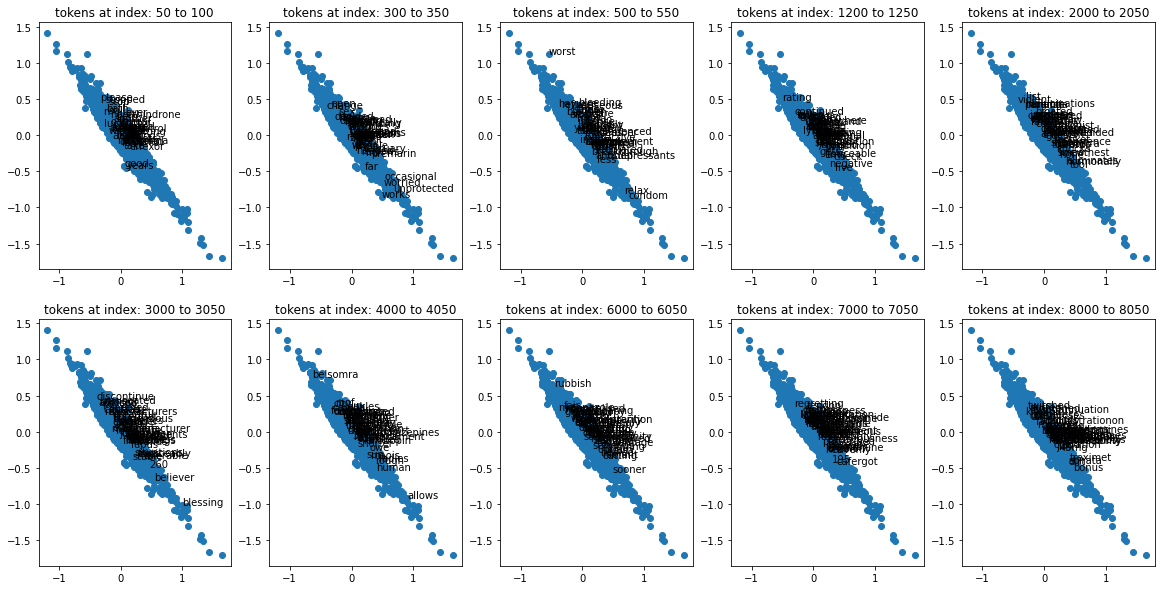

In [40]:
nrows, ncols = 2,5 
partitions_min = [50, 300,  500, 1200, 2000, 3000, 4000, 6000, 7000, 8000]
partitions_max = [100, 350, 550, 1250, 2050, 3050, 4050, 6050, 7050, 8050]
f, axs = plt.subplots(nrows, ncols, figsize=(20,10))

for idx, ax in enumerate(axs.flatten()):
    ax.scatter(
        embeddings_trained[:,0],
        embeddings_trained[:,1]
    )
    
    for i, token in enumerate(train_vocab):
        if i >= partitions_min[idx] and i <= partitions_max[idx]:
            ax.annotate(token, (embeddings_trained[i][0:2]))
            ax.set_title('tokens at index: ' + str(partitions_min[idx]) + ' to ' + str(partitions_max[idx]))




<span style="color:chocolate">Question 1:</span> Have the learned embeddings separated positive and negative words? What is the most negative word? Does this make sense?

<span style="color:chocolate">Question 2:</span> Can you explain what you think the learned PCA embeddings mean?

---
## Evaluation

Evaluation is one of the most important parts of machine learning as it helps us determine how good our trained model is in predicting unseen data.

Notice that `test_data` was not used in the training part. It would be very bad practice to evaluate the model on the test set, and then return and update the model based on those results (then the test set is acting like just another validation set). 

In [41]:
test_results = model.evaluate(test_data)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

575/575 [==============================] - 16s 27ms/step - loss: 0.3131 - accuracy: 0.8767

Test Acc. 87.67%


Finally, let's look at only one example in the test data:

In [50]:
# predict probabilities
predictions = model.predict(test_data)

for ex in test_data.take(1):
    print('Printing encoded example:')
    print('-------------------------')
    print(ex[0].numpy()[0]) # test data is a mini-batch, keep only the first example in the first batch
    
    print('\nPrinting decoded example:')
    print('-------------------------')
    print(encoder.decode(ex[0].numpy()[0]))
    
    print('\nPrinting prediction of example:')
    print('-------------------------------')
    if predictions[0] < 0.5:
        print('Negative drug review with probability', predictions[0]*100)
    else:
        print('Positive drug review with probability', predictions[0]*100)
        
    print('\nPrinting ground truth of example:')
    print('-----------------------------------')
    ground_truth = ex[1].numpy()[0]
    if ground_truth == 0:
        print('Negative')
    else:
        print('Positive')

Printing encoded example:
-------------------------
[  56  360 1544 9804 1357  772   43 2195 2175   35  970   33  164 4732
   33    6 5101  277  289    4  538  138  820  316  121   40   58  141
   43 7006  538  138  820  372   42  173 1801   43   73  164   80   99
 2469   47   48    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]

Printing decoded example:
-------------------------
doctor tried ms contin morphine er it lasts six to eight hours not twelve hours i scream dai